In [364]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
trainSeting=pd.read_excel(r'xxx')

In [365]:
trainSeting=trainSeting.set_index('时间')

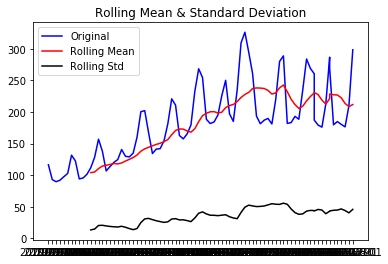

Results of Augment Dickey-Fuller Test:
Test Statistic                 -1.885174
p-value                         0.339068
#Lags Used                     12.000000
Number of Observations Used    69.000000
Critical Value (1%)            -3.528890
dtype: float64
Test Statistic                 -1.885174
p-value                         0.339068
#Lags Used                     12.000000
Number of Observations Used    69.000000
Critical Value (1%)            -3.528890
Critical Value (5%)            -2.904440
dtype: float64
Test Statistic                 -1.885174
p-value                         0.339068
#Lags Used                     12.000000
Number of Observations Used    69.000000
Critical Value (1%)            -3.528890
Critical Value (5%)            -2.904440
Critical Value (10%)           -2.589656
dtype: float64


In [366]:
#ADF
#滚动统计
def rolling_statistics(timeseries):
    #Determing rolling statistics
#     rolmean = pd.rolling_mean(timeseries, window=12)
    rolmean = timeseries.rolling(12).mean()
#     rolstd = pd.rolling_std(timeseries, window=12)
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
##ADF检验
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    rolling_statistics(timeseries)#绘图
#     timeseries.rolling().statistics
    print ('Results of Augment Dickey-Fuller Test:')
    dftest = adfuller(np.array(trainSeting['销量']), autolag='AIC') #？？？
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value   #增加后面的显著性水平的临界值
#     if dfoutput[1]>0.05:
#         print(1)
#         trainSeting = trainSeting.diff(2)
#         trainSeting.dropna(inplace=True)
#         adf_test(timeseries)
#     else:
        print (dfoutput)
    
adf_test(trainSeting)  


In [ ]:
trainSeting2 = trainSeting.diff(1)
trainSeting2.dropna(inplace=True)
trainSeting2

In [ ]:
#白噪音
from statsmodels.stats.diagnostic import acorr_ljungbox
def test_stochastic(ts,lag):
    p_value = acorr_ljungbox(ts, lags=lag) #lags可自定义
    return p_value
test_stochastic(trainSeting2,1)

In [ ]:
float(test_stochastic(trainSeting,1)[1])

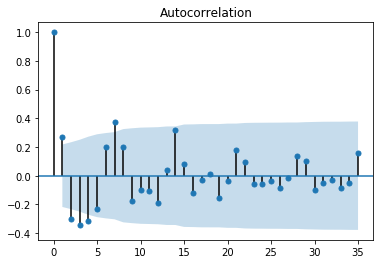

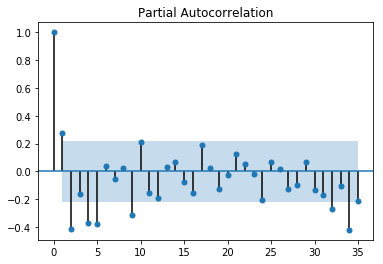

In [370]:
####自相关图ACF和偏相关图PACF
import statsmodels.api as sm
def acf_pacf_plot(ts_log_diff):
    sm.graphics.tsa.plot_acf(ts_log_diff,lags=35) #ARIMA,q
    sm.graphics.tsa.plot_pacf(ts_log_diff,lags=35) #ARIMA,p
    
acf_pacf_plot(trainSeting2)   #查看数据的自相关图和偏自相关图

In [ ]:
##借助AIC、BIC统计量自动确定
from statsmodels.tsa.arima_model import ARMA
def proper_model(data_ts, maxLag): 
    init_bic = float("inf")
    init_p = 0
    init_q = 0
    init_properModel = None
    for p in np.arange(maxLag):
        for q in np.arange(maxLag):
            model = ARMA(data_ts, order=(p, q))
            try:
                results_ARMA = model.fit(disp=-1, method='css')
            except:
                continue
            bic = results_ARMA.bic
            if bic < init_bic:
                init_p = p
                init_q = q
                init_properModel = results_ARMA
                init_bic = bic
    return init_bic, init_p, init_q, init_properModel

proper_model(trainSeting2,5)


In [ ]:
#在statsmodels包里还有更直接的函数：
import statsmodels.tsa.stattools as st
order = st.arma_order_select_ic(trainSeting2,max_ar=5,max_ma=5,ic=['aic', 'bic', 'hqic'])
order.bic_min_order
# '''
# 我们常用的是AIC准则，AIC鼓励数据拟合的优良性但是尽量避免出现过度拟合(Overfitting)的情况。所以优先考虑的模型应是AIC值最小的那一个模型。
# 为了控制计算量，我们限制AR最大阶不超过5，MA最大阶不超过5。 但是这样带来的坏处是可能为局部最优。
# timeseries是待输入的时间序列，是pandas.Series类型，max_ar、max_ma是p、q值的最大备选值。
# order.bic_min_order返回以BIC准则确定的阶数，是一个tuple类型

In [ ]:
################################模型######################################
# AR模型，q=0
#RSS是残差平方和
# disp为-1代表不输出收敛过程的信息，True代表输出
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(trainSeting,order=(4,1,3)) #第二个参数代表使用了二阶差分 #？？？
results_AR = model.fit(disp=-1)
plt.plot(trainSeting2)
plt.plot(results_AR.fittedvalues, color='red') #红色线代表预测值

plt.title('RSS:%.4f' % sum((results_AR.fittedvalues-trainSeting2.销量)**2))#残差平方和
print('RMSE:%.4f' % np.sqrt(sum((results_AR.fittedvalues-trainSeting2.销量)**2)/(trainSeting.销量[1:].shape[0])))#均方根误差

In [ ]:
############################预测未来走势##########################################
# forecast方法会自动进行差分还原，当然仅限于支持的1阶和2阶差分
forecast_n = 12 #预测未来12个天走势
forecast_AR = results_AR.forecast(forecast_n)
forecast_AR = forecast_AR[0]
print (forecast_AR)

In [ ]:

import arrow
def get_date_range(start, limit, level='day',format='YYYY-MM-DD'):
    start = arrow.get(start, format)  
    result=(list(map(lambda dt: dt.format(format) , arrow.Arrow.range(level, start,limit=limit))))
    dateparse2 = lambda dates:pd.datetime.strptime(dates,'%Y-%m-%d')
    return map(dateparse2, result)


new_index = get_date_range('2019-06-01', forecast_n)

forecast_ARIMA_log = pd.Series(forecast_AR, copy=True, index=new_index)
forecast_ARIMA_log = pd.DataFrame(forecast_ARIMA_log)
print (forecast_ARIMA_log.head())
trainSeting.index=pd.to_datetime(trainSeting.index,format='%Y-%m-%d')
forecast_ARIMA_log.index=pd.to_datetime(forecast_ARIMA_log.index,format='YYYY-MM-DD')
##绘图如下
plt.plot(trainSeting,label='Original',color='blue')
plt.plot(forecast_ARIMA_log, label='Forcast',color='red')
plt.legend(loc='best')
plt.title('forecast')

In [353]:
train_predict = results_AR.predict()
train_predict = train_predict.shift(0)

In [384]:
predict_ts = results_AR.predict()
# 一阶差分还原
predict_ts2 = trainSeting.shift(1)
diff_recover_1 = predict_ts.add(predict_ts2['销量'])

In [391]:
diff_recover_1 = diff_recover_1[1:]

In [ ]:
diff_recover_1.head(3)

In [ ]:
predict_ts
plt.figure(facecolor='white')
diff_recover_1.plot(color='blue', label='Predict')
trainSeting[1:]['销量'].plot(color='red', label='Original')
plt.legend(loc='best')
plt.title('RMSE: %.4f'% np.sqrt(sum((diff_recover_1-trainSeting[1:]['销量'])**2)/trainSeting[1:]['销量'].size))
plt.show()


print('RSS:%.4f' % sum((diff_recover_1-trainSeting[1:]['销量'])**2))#残差平方和